## Movielens

In [31]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.learner import *
from fastai.column_data import *

Data available from http://files.grouplens.org/datasets/movielens/ml-latest-small.zip

In [32]:
path='data/ml-latest-small/'

We're working with the movielens data, which contains one rating per row, like this:

In [33]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


Just for display purposes, let's read in the movie names too.

In [34]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Create subset for Excel

We create a crosstab of the most popular movies and most movie-addicted users which we'll copy into Excel for creating a simple example. This isn't necessary for any of the modeling below however.

In [35]:
g=ratings.groupby('userId')['rating'].count()
topUsers=g.sort_values(ascending=False)[:15]

g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False)[:15]

top_r = ratings.join(topUsers, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(topMovies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

movieId,1,110,260,296,318,356,480,527,589,593,608,1196,1198,1270,2571
userId,,,,,,,,,,,,,,,
15,2.0,3.0,5.0,5.0,2.0,1.0,3.0,4.0,4.0,5.0,5.0,5.0,4.0,5.0,5.0
30,4.0,5.0,4.0,5.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,4.0,5.0,5.0,3.0
73,5.0,4.0,4.5,5.0,5.0,5.0,4.0,5.0,3.0,4.5,4.0,5.0,5.0,5.0,4.5
212,3.0,5.0,4.0,4.0,4.5,4.0,3.0,5.0,3.0,4.0,NaN,NaN,3.0,3.0,5.0
213,3.0,2.5,5.0,NaN,NaN,2.0,5.0,NaN,4.0,2.5,2.0,5.0,3.0,3.0,4.0
294,4.0,3.0,4.0,NaN,3.0,4.0,4.0,4.0,3.0,NaN,NaN,4.0,4.5,4.0,4.5
311,3.0,3.0,4.0,3.0,4.5,5.0,4.5,5.0,4.5,2.0,4.0,3.0,4.5,4.5,4.0
380,4.0,5.0,4.0,5.0,4.0,5.0,4.0,NaN,4.0,5.0,4.0,4.0,NaN,3.0,5.0
452,3.5,4.0,4.0,5.0,5.0,4.0,5.0,4.0,4.0,5.0,5.0,4.0,4.0,4.0,2.0


## Collaborative filtering

In [36]:
val_idxs = get_cv_idxs(len(ratings))
wd=2e-4 # weight decay, L2 regularization
n_factors = 50 # it is the dimensionality of the embedding matrix

In [37]:
cf = CollabFilterDataset.from_csv(path, 'ratings.csv', 'userId', 'movieId', 'rating')
learn = cf.get_learner(n_factors, val_idxs, 64, opt_fn=optim.Adam)

In [38]:
learn.fit(1e-2, 2, wds=wd, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.822403   0.805803  
    1      0.770535   0.780825                                  
    2      0.607988   0.766287                                  



[0.7662868]

Let's compare to some benchmarks. Here's [some benchmarks](https://www.librec.net/release/v1.3/example.html) on the same dataset for the popular Librec system for collaborative filtering. They show best results based on [RMSE](http://www.statisticshowto.com/rmse/) of 0.91. We'll need to take the square root of our loss, since we use plain MSE.

In [39]:
math.sqrt(0.776)

0.8809086218218096

Looking good - we've found a solution better than any of those benchmarks! Let's take a look at how the predictions compare to actuals for this model.

In [40]:
preds = learn.predict()

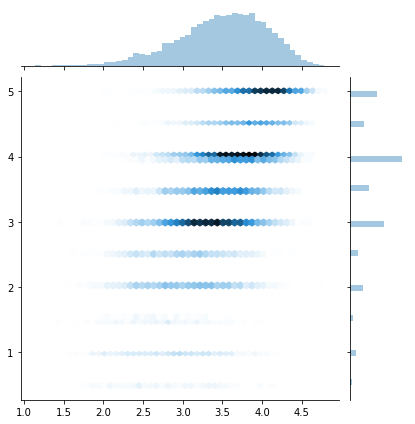

In [41]:
y=learn.data.val_y
sns.jointplot(preds, y, kind='hex', stat_func=None);

## Analyze results

### Movie bias

In [42]:
movie_names = movies.set_index('movieId')['title'].to_dict()
g=ratings.groupby('movieId')['rating'].count()
topMovies=g.sort_values(ascending=False).index.values[:3000]
topMovieIdx = np.array([cf.item2idx[o] for o in topMovies])

@property in ptyhon is used to wrap a method/function which later calling from the class instance can be called withouth the ()

In [43]:
m=learn.model; m.cuda()  

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

In [44]:
learn.models.model

EmbeddingDotBias(
  (u): Embedding(671, 50)
  (i): Embedding(9066, 50)
  (ub): Embedding(671, 1)
  (ib): Embedding(9066, 1)
)

First, we'll look at the movie bias term. Here, our input is the movie id (a single id), and the output is the movie bias (a single float).

In [45]:
m.ib(V(topMovieIdx)) 

Variable containing:
 8.0033e-01
 9.0528e-01
 1.3345e+00
     ⋮      
 3.6123e-01
-3.3098e-02
 1.5708e-01
[torch.cuda.FloatTensor of size 3000x1 (GPU 0)]

In [46]:
movie_bias = to_np(m.ib(V(topMovieIdx)))  # V is to turn the tensor into a variable, to_np is to change tensor to numpy array

**Rule of thumb: use numpy unless encouter GPU calculation or gradient**

**To move the model to CPU, type:**

m.cpu()

**TO move back to GPU, type:**

m.cuda()

In [47]:
movie_bias

array([[ 0.80033],
       [ 0.90528],
       [ 1.33448],
       ...,
       [ 0.36123],
       [-0.0331 ],
       [ 0.15708]], dtype=float32)

In [48]:
movie_ratings = [(b[0], movie_names[i]) for i,b in zip(topMovies,movie_bias)]

Now we can look at the top and bottom rated movies. These ratings are corrected for different levels of reviewer sentiment, as well as different types of movies that different reviewers watch.

In [49]:
sorted(movie_ratings, key=lambda o: o[0])[:15]

[(-0.933721, 'Battlefield Earth (2000)'),
 (-0.76425683, 'Speed 2: Cruise Control (1997)'),
 (-0.70317626, 'Anaconda (1997)'),
 (-0.68327296, 'Wild Wild West (1999)'),
 (-0.68030316, 'Inspector Gadget (1999)'),
 (-0.6731652, 'Batman & Robin (1997)'),
 (-0.66738725, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.65995514, 'Super Mario Bros. (1993)'),
 (-0.65405935, 'Superman III (1983)'),
 (-0.65239036, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.6473835, 'Congo (1995)'),
 (-0.6406223, 'Godzilla (1998)'),
 (-0.6404701, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.5989767, 'Message in a Bottle (1999)'),
 (-0.5772424, 'Little Nicky (2000)')]

In [50]:
sorted(movie_ratings, key=itemgetter(0))[:15]

[(-0.933721, 'Battlefield Earth (2000)'),
 (-0.76425683, 'Speed 2: Cruise Control (1997)'),
 (-0.70317626, 'Anaconda (1997)'),
 (-0.68327296, 'Wild Wild West (1999)'),
 (-0.68030316, 'Inspector Gadget (1999)'),
 (-0.6731652, 'Batman & Robin (1997)'),
 (-0.66738725, 'Mighty Morphin Power Rangers: The Movie (1995)'),
 (-0.65995514, 'Super Mario Bros. (1993)'),
 (-0.65405935, 'Superman III (1983)'),
 (-0.65239036, 'Police Academy 5: Assignment: Miami Beach (1988)'),
 (-0.6473835, 'Congo (1995)'),
 (-0.6406223, 'Godzilla (1998)'),
 (-0.6404701, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.5989767, 'Message in a Bottle (1999)'),
 (-0.5772424, 'Little Nicky (2000)')]

In [51]:
sorted(movie_ratings, key=lambda o: o[0], reverse=True)[:15]

[(1.3344839, 'Shawshank Redemption, The (1994)'),
 (1.1396923, 'Godfather, The (1972)'),
 (1.112354, 'Usual Suspects, The (1995)'),
 (0.9536169, "Schindler's List (1993)"),
 (0.9294349, 'Matrix, The (1999)'),
 (0.9266707, 'Godfather: Part II, The (1974)'),
 (0.9052752, 'Pulp Fiction (1994)'),
 (0.8976544, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.88531166, '12 Angry Men (1957)'),
 (0.8792621, 'Fargo (1996)'),
 (0.872096, 'To Kill a Mockingbird (1962)'),
 (0.86171305, 'Silence of the Lambs, The (1991)'),
 (0.8612071, 'Memento (2000)'),
 (0.83566797, 'African Queen, The (1951)'),
 (0.83254594, 'Princess Bride, The (1987)')]

### Embedding interpretation

We can now do the same thing for the embeddings.

In [52]:
movie_emb = to_np(m.i(V(topMovieIdx)))
movie_emb.shape

(3000, 50)

Because it's hard to interpret 50 embeddings, we use [PCA](https://plot.ly/ipython-notebooks/principal-component-analysis/) to simplify them down to just 3 vectors. 

In [53]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
movie_pca = pca.fit(movie_emb.T).components_

In [54]:
movie_pca.shape

(3, 3000)

In [55]:
fac0 = movie_pca[0]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac0, topMovies)]

Here's the 1st component. It seems to be 'easy watching' vs 'serious'.

In [56]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07601126, 'Pulp Fiction (1994)'),
 (0.07600421, 'Godfather, The (1972)'),
 (0.0719351, 'Godfather: Part II, The (1974)'),
 (0.06867923, 'Taxi Driver (1976)'),
 (0.06740917, 'Goodfellas (1990)'),
 (0.067227505, 'Chinatown (1974)'),
 (0.06623383, 'Clockwork Orange, A (1971)'),
 (0.0649385, '2001: A Space Odyssey (1968)'),
 (0.0623883, 'Apocalypse Now (1979)'),
 (0.05923191, 'This Is Spinal Tap (1984)')]

In [57]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.07103642, 'Armageddon (1998)'),
 (-0.0661325, 'Police Academy 4: Citizens on Patrol (1987)'),
 (-0.06437175, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.05536564, 'Outbreak (1995)'),
 (-0.055120878, 'Lethal Weapon 4 (1998)'),
 (-0.054900136, 'Batman Forever (1995)'),
 (-0.054799754, "Charlie's Angels (2000)"),
 (-0.053438637, 'Mission: Impossible II (2000)'),
 (-0.05250184, 'Pay It Forward (2000)'),
 (-0.052114937, 'Anaconda (1997)')]

In [58]:
fac1 = movie_pca[1]
movie_comp = [(f, movie_names[i]) for f,i in zip(fac1, topMovies)]

Here's the 2nd component. It seems to be 'CGI' vs 'dialog driven'.

In [59]:
sorted(movie_comp, key=itemgetter(0), reverse=True)[:10]

[(0.07180581, 'Postman, The (Postino, Il) (1994)'),
 (0.063263126, 'Bringing Up Baby (1938)'),
 (0.05774263, 'Specialist, The (1994)'),
 (0.054366406, 'Trainspotting (1996)'),
 (0.05217171, 'Battlefield Earth (2000)'),
 (0.04863528, 'Blind Swordsman: Zatoichi, The (Zatôichi) (2003)'),
 (0.04708891, 'Brokeback Mountain (2005)'),
 (0.046350595, 'Island of Dr. Moreau, The (1996)'),
 (0.044336583, '8 1/2 (8½) (1963)'),
 (0.043585405, 'Leaving Las Vegas (1995)')]

In [60]:
sorted(movie_comp, key=itemgetter(0))[:10]

[(-0.10970197, 'Jurassic Park (1993)'),
 (-0.108255595,
  'Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)'),
 (-0.10439497, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (-0.09600309, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (-0.09083191, 'Forrest Gump (1994)'),
 (-0.0883195, 'Lethal Weapon (1987)'),
 (-0.08507966, 'Star Wars: Episode IV - A New Hope (1977)'),
 (-0.0850775, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (-0.08230489, 'Gladiator (2000)'),
 (-0.08141897, 'Dark Knight, The (2008)')]

We can draw a picture to see how various movies appear on the map of these components. This picture shows the first two components.

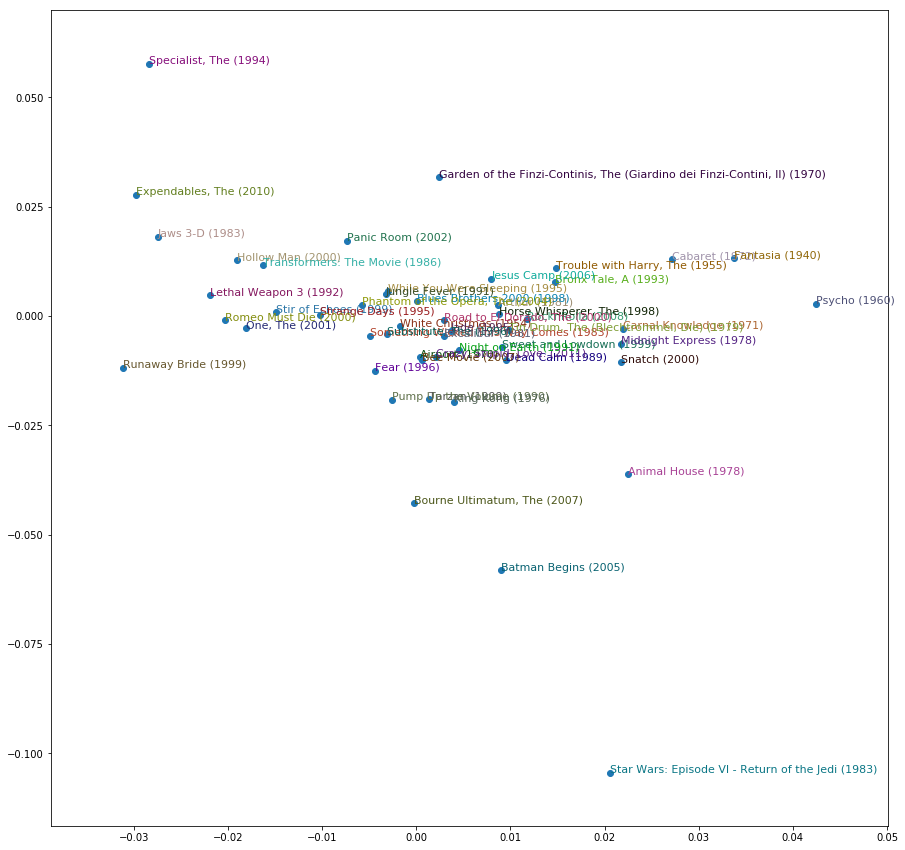

In [61]:
idxs = np.random.choice(len(topMovies), 50, replace=False)
X = fac0[idxs]
Y = fac1[idxs]
plt.figure(figsize=(15,15))
plt.scatter(X, Y)
for i, x, y in zip(topMovies[idxs], X, Y):
    plt.text(x,y,movie_names[i], color=np.random.rand(3)*0.7, fontsize=11)
plt.show()

## Collab filtering from scratch

### Dot product example

In [30]:
a = T([[1.,2],[3,4]])
b = T([[2.,2],[10,10]])
a,b

(
  1  2
  3  4
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)], 
   2   2
  10  10
 [torch.cuda.FloatTensor of size 2x2 (GPU 0)])

In [31]:
a*b # elementwise multiplication


  2   4
 30  40
[torch.cuda.FloatTensor of size 2x2 (GPU 0)]

In [32]:
(a*b).sum(1) # sum across the fist dimension, which is the column


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

In [33]:
class DotProduct(nn.Module): ## the nn.Module is used to create layers for the network then later can be caleed to get the gradients
    def forward(self, u, m): return (u*m).sum(1) # a forward operation 

In [34]:
model=DotProduct()

In [35]:
model(a,b)


  6
 70
[torch.cuda.FloatTensor of size 2 (GPU 0)]

### Dot product model

In [36]:
u_uniq = ratings.userId.unique() # create the contiguous list for the userid
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())

In [37]:
class EmbeddingDot(nn.Module): # inheriting the parent class -- nn.Module
    def __init__(self, n_users, n_movies): # constructor for the class
        super().__init__()  ### ineriting the behavior of the parent class
        self.u = nn.Embedding(n_users, n_factors)
        self.m = nn.Embedding(n_movies, n_factors)
        self.u.weight.data.uniform_(0,0.05) # initialization
        self.m.weight.data.uniform_(0,0.05)
        
    def forward(self, cats, conts): # cats = cateogorical varialbles, conts = continuous variables
        users,movies = cats[:,0],cats[:,1]
        u,m = self.u(users),self.m(movies)
        return (u*m).sum(1)

**an embedding is a variable, it is a tensor and has automatic differentiation**

to get the tensor(data) from a variable, use .data as in the above code

_ an underscore in the function is the apply the function inplace, thus:

self.u.weight.data.uniform_(0,0.05) is equivalent to 
self.u.weigth.data = self.u.weight.data.uniform(0, 0.05)



In [38]:
x = ratings.drop(['rating', 'timestamp'],axis=1)
y = ratings['rating'].astype(np.float32)

In [39]:
data = ColumnarModelData.from_data_frame(path, val_idxs, x, y, ['userId', 'movieId'], 64)

In [40]:
wd=1e-5
model = EmbeddingDot(n_users, n_movies).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9) # optimizer 

In [41]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                 
    0      1.586123   1.646353  
    1      1.107773   1.298699                                 
    2      0.903994   1.225577                                  



[1.2255772]

In [42]:
set_lrs(opt, 0.01)

In [43]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.721533   1.145945  
    1      0.666431   1.134411                                  
    2      0.659481   1.128951                                  



[1.1289508]

### Bias

In [44]:
min_rating,max_rating = ratings.rating.min(),ratings.rating.max()
min_rating,max_rating

(0.5, 5.0)

In [45]:
def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.01,0.01) # the parameters are for random initialization
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_users, n_movies):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors), (n_users,1), (n_movies,1)
        ]]
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        um = (self.u(users)* self.m(movies)).sum(1)
        res = um + self.ub(users).squeeze() + self.mb(movies).squeeze() # broadcasting vector to be compatible with the maxtri
        res = F.sigmoid(res) * (max_rating-min_rating) + min_rating # make it in a desirable range
        return res

In [46]:
wd=2e-4
model = EmbeddingDotBias(cf.n_users, cf.n_items).cuda()
opt = optim.SGD(model.parameters(), 1e-1, weight_decay=wd, momentum=0.9)

In [47]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.806194   0.838323  
    1      0.810499   0.820472                                  
    2      0.755106   0.806979                                  



[0.8069791]

In [48]:
set_lrs(opt, 1e-2) # reset learning rate 

In [49]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.764101   0.802096  
    1      0.717204   0.800888                                  
    2      0.728773   0.800292                                  



[0.8002916]

### Mini net

In [50]:
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5): # define the layer definition
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):  # actual layer architechture 
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [51]:
wd=1e-5
model = EmbeddingNet(n_users, n_movies).cuda() # .cuda() is to put the data to gpu for calculation
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=wd)

In [52]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.874043   0.816223  
    1      0.837344   0.795688                                  
    2      0.800413   0.792643                                  



[0.7926432]

In [53]:
set_lrs(opt, 1e-3)

In [54]:
fit(model, data, 3, opt, F.mse_loss)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss                                  
    0      0.76378    0.793689  
    1      0.724114   0.789982                                  
    2      0.777828   0.789614                                  



[0.7896143]

A dense layer is a linear layer